In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb 
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import time

##### Load data và chọn lựa features, chia thành train và test

In [80]:
# Load data
df = pd.read_csv('01_dataset.csv', index_col='customer_id')
df_imputed = pd.read_csv('cleaned_data_new.csv', index_col='customer_id')

In [81]:
# Loại bỏ các cột không cần thiết
drop_cols = [col for col in df.columns if 'OUTSTANDING' in col]
drop_cols += ['label', 'CREDIT_CARD_MONTH_SINCE_10DPD', 'CREDIT_CARD_MONTH_SINCE_30DPD',
       'CREDIT_CARD_MONTH_SINCE_60DPD', 'CREDIT_CARD_MONTH_SINCE_90DPD',
       'CREDIT_CARD_NUMBER_OF_LATE_PAYMENT']

In [217]:
# Chia dữ liệu thành tập train và test, chuẩn hóa dữ liệu
X = df_imputed.drop(columns=drop_cols, axis=1)
y = df_imputed['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

##### LightGBM

In [218]:
param = {'num_leaves': 75, 'objective': 'binary'}
param['metric'] = 'auc'

t1 = time.time()
num_round = 100
bst = lgb.train(param, train_data, num_round)
t2 = time.time()
t_lgb = t2 - t1

[LightGBM] [Info] Number of positive: 2915, number of negative: 13085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9918
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182188 -> initscore=-1.501597
[LightGBM] [Info] Start training from score -1.501597


In [220]:
ybar_proba_lgm = bst.predict(X_train)
ybar_lgm = [1 if x >= 0.5 else 0 for x in ybar_proba_lgm]
ypred_proba_lgm = bst.predict(X_test)
ypred_lgm = [1 if x >= 0.5 else 0 for x in ypred_proba_lgm]
print('Accuracy for train data: {}%'.format(accuracy_score(y_train, ybar_lgm)*100))
print('Accuracy for validation data: {}%'.format(accuracy_score(y_test, ypred_lgm)*100))
auc_lgm = roc_auc_score(y_test, ypred_proba_lgm)
print('AUC: {}'.format(auc_lgm))

Accuracy for train data: 98.5375%
Accuracy for validation data: 91.95%
AUC: 0.9005191316297898


##### Random Forest Classifier

In [221]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=30)
t1 = time.time()
rfc.fit(X_train_scaled, y_train)
t2 = time.time()
ybar_rfc = rfc.predict(X_train_scaled)
ypred_rfc = rfc.predict(X_test_scaled)
t_rfc = t2 - t1
print('Accuracy for train data: {}%'.format(accuracy_score(y_train, ybar_rfc)*100))
print('Accuracy for test data: {}%'.format(accuracy_score(y_test, ypred_rfc)*100))
auc_rfc = roc_auc_score(y_test, ypred_rfc)
print('AUC: {}'.format(auc_rfc))

Accuracy for train data: 98.6125%
Accuracy for test data: 89.1%
AUC: 0.7212146983991589


##### XGBoost

In [222]:
xgb_model = xgb.XGBClassifier(random_state=42)
t1 = time.time()
xgb_model.fit(X_train_scaled, y_train)
t2 = time.time()
t_xgb = t2 - t1
ybar_xgb = xgb_model.predict(X_train_scaled)
ypred_xgb = xgb_model.predict(X_test_scaled)
print('Accuracy for train data: {}%'.format(accuracy_score(y_train, ybar_xgb)*100))
print('Accuracy for test data: {}%'.format(accuracy_score(y_test, ypred_xgb)*100))
auc_xgb = roc_auc_score(y_test, ypred_xgb)
print('AUC: {}'.format(auc_xgb))

Accuracy for train data: 97.9375%
Accuracy for test data: 91.475%
AUC: 0.7826413605199116


##### SVM

In [224]:
svm_model = SVC(gamma='scale', random_state=42)
t1 = time.time()
svm_model.fit(X_train, y_train)
t2 = time.time()
t_svm = t2 - t1
ybar_svm = svm_model.predict(X_train_scaled)
ypred_svm = svm_model.predict(X_test_scaled)
print('Accuracy for train data: {}%'.format(accuracy_score(y_train, ybar_svm)*100))
print('Accuracy for test data: {}%'.format(accuracy_score(y_test, ypred_svm)*100))
auc_svm = roc_auc_score(y_test, ypred_svm)
print('AUC: {}'.format(auc_svm))

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Accuracy for train data: 81.78125%
Accuracy for test data: 81.77499999999999%
AUC: 0.5


In [225]:
table = dict({'LightGBM': [f'{accuracy_score(y_train, ybar_lgm)*100: .2f}%', f'{accuracy_score(y_test, ypred_lgm)*100: .2f}%', f'{auc_lgm: .2f}', f'{t_lgb: .2f}s'],
              'Random Forest': [f'{accuracy_score(y_train, ybar_rfc)*100: .2f}%', f'{accuracy_score(y_test, ypred_rfc)*100: .2f}%', f'{auc_rfc: .2f}', f'{t_rfc: .2f}s'],
                'XGBoost': [f'{accuracy_score(y_train, ybar_xgb)*100: .2f}%', f'{accuracy_score(y_test, ypred_xgb)*100: .2f}%', f'{auc_xgb: .2f}', f'{t_xgb: .2f}s'],
                'SVM': [f'{accuracy_score(y_train, ybar_svm)*100: .2f}%', f'{accuracy_score(y_test, ypred_svm)*100: .2f}%', f'{auc_svm: .2f}', f'{t_svm: .2f}s']})
table = pd.DataFrame(table, index=['Train', 'Test', 'AUC_score','Time'])
table

,LightGBM,Random Forest,XGBoost,SVM
Train,98.54%,98.61%,97.94%,81.78%
Test,91.95%,89.10%,91.47%,81.77%
AUC_score,0.90,0.72,0.78,0.50
Time,0.66s,0.53s,0.49s,13.63s


In [226]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

test_data = lgb.Dataset(X_test, label=y_test)
val_data = lgb.Dataset(X_val, label=y_val)

Text(50.722222222222214, 0.5, 'True')

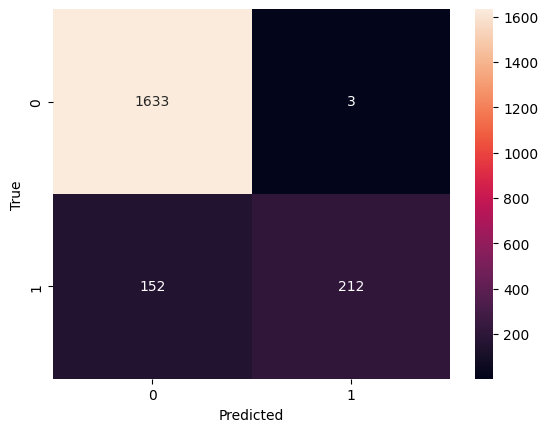

In [261]:
ypred_proba = bst.predict(X_test)
ypred = [1 if x >= 0.5 else 0 for x in ypred_proba]

cm = confusion_matrix(y_test, ypred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

#### Tìm siêu tham số cho mô hình bằng Grid Search

In [227]:
param_grid = {'boosting_type':['gbdt'], 'num_leaves': [50, 75, 100, 200], 'max_depth': [-1, 10, 20, 30], 'learning_rate': [0.1, 0.05, 0.2], 'n_estimators': [100, 200, 300, 400]}

param_list = [(boosting_type, num_leaves, max_depth, learning_rate, n_estimators) for boosting_type in param_grid['boosting_type'] for num_leaves in param_grid['num_leaves'] for max_depth in param_grid['max_depth'] for learning_rate in param_grid['learning_rate'] for n_estimators in param_grid['n_estimators']]
print(param_list)
results = {'num_leaves':[], 'max_depth':[], 'learning_rate':[], 'n_estimators':[], 'accuracy_train':[], 'accuracy_val':[], 'accuracy_train':[]}
for boosting_type, num_leaves, max_depth, learning_rate, n_estimators in param_list:

    model = lgb.LGBMClassifier(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

    results['num_leaves'].append(num_leaves)
    results['max_depth'].append(max_depth)
    results['learning_rate'].append(learning_rate)
    results['n_estimators'].append(n_estimators)

    model.fit(X_train, y_train)

    y_bar = model.predict(X_train)
    y_pred = model.predict(X_test)

    accuracy_train = accuracy_score(y_train, y_bar)
    accuracy_val = accuracy_score(y_test, y_pred)
    
    results['accuracy_train'].append(accuracy_train)
    results['accuracy_val'].append(accuracy_val)

    print(f'num_leaves: {num_leaves}, max_depth: {max_depth}, learning_rate: {learning_rate}, n_estimators: {n_estimators}, accuracy_train: {accuracy_train}, accuracy_val: {accuracy_val}')


In [81]:
results = pd.DataFrame(results)
results.sort_values(by='accuracy_val', ascending=False).head(20)

,num_leaves,max_depth,learning_rate,n_estimators,accuracy_train,accuracy_val
57,75,-1,0.20,200,1.000000,0.9260
49,75,-1,0.10,200,0.999875,0.9255
143,100,30,0.20,400,1.000000,0.9255
129,100,20,0.20,200,1.000000,0.9255
11,50,-1,0.20,400,1.000000,0.9250
38,50,30,0.10,300,0.999687,0.9250
58,75,-1,0.20,300,1.000000,0.9250
59,75,-1,0.20,400,1.000000,0.9250
87,75,30,0.10,400,1.000000,0.9250
51,75,-1,0.10,400,1.000000,0.9250


In [230]:
model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=50, max_depth=-1, learning_rate=0.2, n_estimators=400, is_unbalance=True, objective='binary', metrics='auc')

model.fit(X_train, y_train)

y_bar = model.predict(X_train)
y_pred = model.predict(X_val)

print('Accuracy for train data: {}%'.format(accuracy_score(y_train, y_bar)*100))
print('Accuracy for test data: {}%'.format(accuracy_score(y_val, y_pred)*100))
print('AUC: {}'.format(roc_auc_score(y_val, y_pred)))

[LightGBM] [Info] Number of positive: 2915, number of negative: 13085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9918
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182188 -> initscore=-1.501597
[LightGBM] [Info] Start training from score -1.501597
Accuracy for train data: 100.0%
Accuracy for test data: 92.2%
AUC: 0.8011981064890453


Text(50.722222222222214, 0.5, 'True')

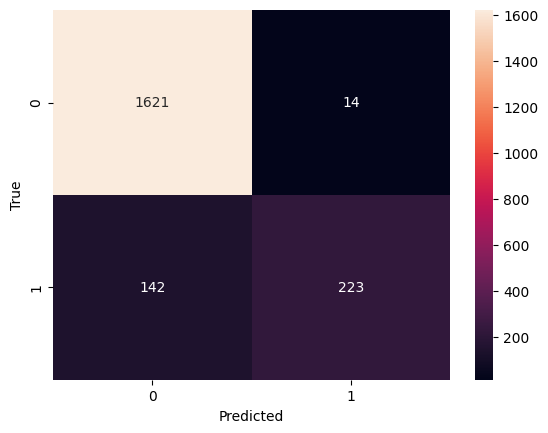

In [231]:
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

In [232]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1635
           1       0.94      0.61      0.74       365

    accuracy                           0.92      2000
   macro avg       0.93      0.80      0.85      2000
weighted avg       0.92      0.92      0.92      2000



In [233]:
print(F'Precision: {precision_score(y_val, y_pred)*100}%')
print(F'Recall: {recall_score(y_val, y_pred)*100}%')
print(F'F1 Score: {f1_score(y_val, y_pred)*100}%')

Precision: 94.09282700421942%
Recall: 61.09589041095891%
F1 Score: 74.08637873754152%


In [255]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'max_depth': -1,
    'num_leaves': 80,
    'n_estimators': 100,
    'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    # 'feature_fraction': 0.8
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, val_data],
)

y_pred_proba = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc:.4f}")

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2915, number of negative: 13085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9918
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.182188 -> initscore=-1.501597
[LightGBM] [Info] Start training from score -1.501597
AUC Score: 0.9194


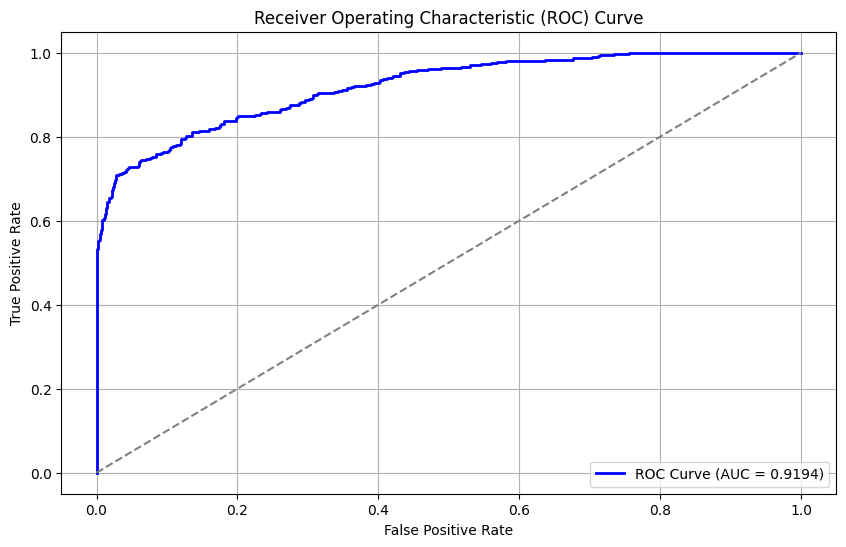

Optimal Threshold: 0.4338


In [256]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold:.4f}')

In [257]:
y_pred = np.where(y_pred_proba >= optimal_threshold, 1, 0)

Text(50.722222222222214, 0.5, 'True')

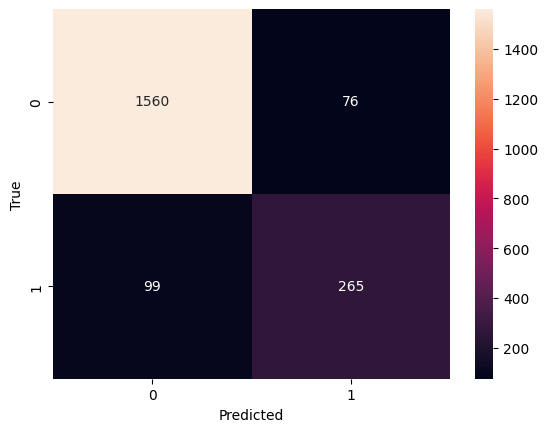

In [258]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

In [259]:
print('Accuracy for train data: {}%'.format(accuracy_score(y_train, y_bar)*100))
print('Accuracy for test data: {}%'.format(accuracy_score(y_test, y_pred)*100))

Accuracy for train data: 100.0%
Accuracy for test data: 91.25%


In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1636
           1       0.56      0.80      0.66       364

    accuracy                           0.85      2000
   macro avg       0.76      0.83      0.78      2000
weighted avg       0.88      0.85      0.86      2000

